In [1]:
import torch
from torchvision import transforms

import sys
sys.path.append('../dcae')

from dcae import DCAE
from datasets import load_dataset, Features, Array3D, Value, Image

In [2]:
# Constants
COMPRESSION_FACTOR = "f32"  # Options: "f32", "f64", "f128"
OG_DATASET = "pravsels/FFHQ_1024"
UPLOAD_DATASET = f"SwayStar123/FFHQ_1024_DC-AE_{COMPRESSION_FACTOR}"
MODEL_PATHS = {
    "f32": "dc-ae-f32c32-mix-1.0",
    "f64": "dc-ae-f64c128-mix-1.0",
    "f128": "dc-ae-f128c512-mix-1.0"
}
CACHE_DIR = "../../models/dc_ae"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16  # Adjust if necessary
BATCH_SIZE = 2  # Configurable batch size

In [3]:

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5,))
])

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

In [4]:
model_name = MODEL_PATHS[COMPRESSION_FACTOR]
dc_ae = DCAE(model_name, device=DEVICE, dtype=DTYPE, cache_dir=CACHE_DIR).eval()


In [5]:
# Get the shape of the latent representations
dummy_input = torch.randn(1, 3, 1024, 1024).to(DTYPE).to(DEVICE)
with torch.no_grad():
    dummy_latent = dc_ae.encode(dummy_input).cpu()
latent_shape = dummy_latent.shape[1:]
print(f"Latent shape: {latent_shape}")

# Define features
features = Features({
    'image': Image(),  # Updated to use Image feature
    'label': Value('int64'),
    'latent': Array3D(dtype='float16', shape=latent_shape)
})

Latent shape: torch.Size([32, 32, 32])


In [6]:
# Load and concatenate train and validation splits
dataset = load_dataset(OG_DATASET, split="train", streaming=True).take(4)

In [7]:
# Process and encode images
def process_batch(batch):
    images = [img.convert("RGB") for img in batch["image"]]
    img_tensors = torch.stack([transform(img) for img in images]).to(DTYPE).to(DEVICE)
    with torch.no_grad():
        latents = dc_ae.encode(img_tensors).cpu().to(torch.float16).numpy()
    batch["latent"] = latents
    return batch

In [8]:
processed_dataset = dataset.map(
    process_batch,
    batched=True,
    batch_size=BATCH_SIZE,
    features=features,
)

In [17]:
processed_dataset = processed_dataset.remove_columns(["image"])

In [18]:
iter_processed_dataset = iter(processed_dataset)

In [10]:
iter_dataset = iter(dataset)

In [19]:
row = next(iter_processed_dataset)

In [11]:
latent = next(iter_processed_dataset)["latent"]

In [12]:
latent.shape

(32, 32, 32)

In [13]:
with torch.no_grad():
    recon = dc_ae.decode(torch.from_numpy(latent).unsqueeze(0).to(DTYPE).to(DEVICE)).cpu().squeeze(0)

In [14]:
recon = denorm(recon).cpu().squeeze(0).to(torch.float16)

In [15]:
# Image from recon
from PIL import Image
import numpy as np

# Convert the recon tensor to a numpy array and transpose it to (H, W, C) format
recon_np = recon.permute(1, 2, 0).numpy()

# Convert the numpy array to a PIL Image
recon_image = Image.fromarray((recon_np * 255).astype(np.uint8))


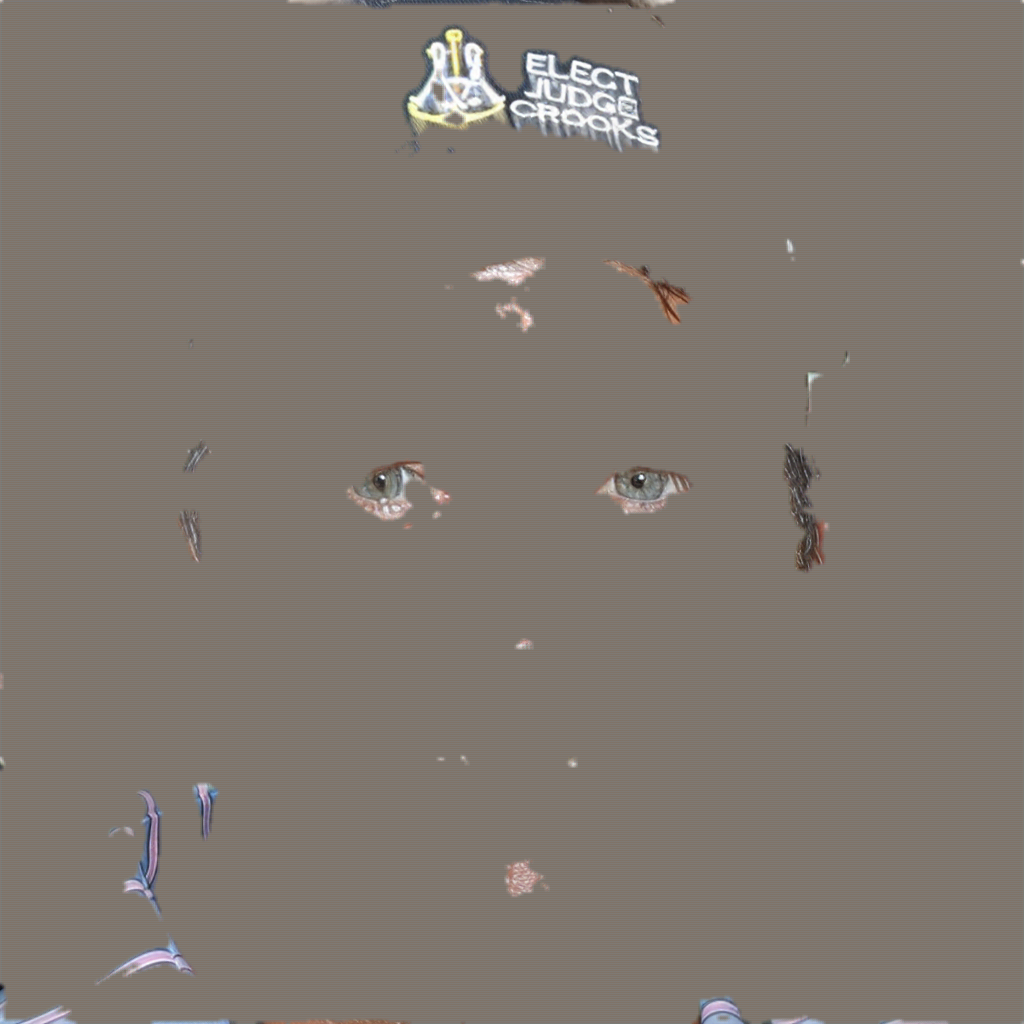

In [16]:
recon_image